In [0]:
%matplotlib inline

# ToDo :
## Target : ```See the accuracy change within 40 epochs on Dilated+Depthwise+Separable convolution and RF more than 44```
##  Results :    ```Parameters: 98,960    Accuracy : 74%```
## Analysis : ```4 Convolution layers and 3 MPs indicate that we want to see Edges&Gradients, Textures&Patterns, Parts Of Objects and Objects.```


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32),
     transforms.RandomRotation((-15.0, 15.0)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Code to check GPU availability

In [4]:
SEED = 1
# Check if CUDA is available
cuda = torch.cuda.is_available()
print("Is CUDA available : ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# Data loader argumens for train and test
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# Train loader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# Test loader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

Is CUDA available :  True


Let us show some of the training images, for fun.



plane   dog  deer  deer


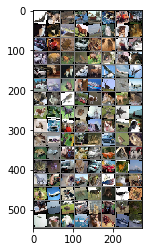

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value=0.20
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ############################### Convolution Block 1 ###############################
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=2, dilation=2, bias=False),# Atrous Convolution
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Dropout2d(dropout_value))# Input=32x32x3 Output=32x32x64 RF=7x7
        ############################## Transition Block 1 ##################################
        self.pool1 = nn.MaxPool2d(2, 2)# Input=32x32x64 Output=16x16x64 RF=8x8
        
        
        
         ############################### Convolution Block 2 ###############################
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Dropout2d(dropout_value))# Input=16x16x64 Output=16x16x128 RF=16x16
        ############################## Transition Block 1 ##################################
        self.pool2 = nn.MaxPool2d(2, 2)# Input=16x16x64 Output=8x8x128 RF=18x18
        
        
        
         ############################### Convolution Block 3 ###############################
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Dropout2d(dropout_value))# Input=8x8x128 Output=8x8x256 RF=34x34
        ############################## Transition Block 1 ##################################
        self.pool3 = nn.MaxPool2d(2, 2)# Input=8x8x128 Output=4x4x128 RF=38x38
        
        
        
         ############################### Convolution Block 4 ###############################
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1, groups=128, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(128),
                                   nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), padding=0, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(256),
                                   nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1, groups=256, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(256),
                                   nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), padding=0, bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(512),
                                   nn.Dropout2d(dropout_value))# Input=4x4x256 Output=4x4x512 RF=60x60
        
        ############################## GAP Layer ##################################
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))# Input=4x4x512 Output=1x1x512 RF=84x84
        
        ############################# 1x1 Layer ###################################
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1,1), padding=0, bias=False))


    def forward(self, x):
      x = self.pool1(self.conv1(x))
      x = self.pool2(self.conv2(x))
      x = self.pool3(self.conv3(x))
      x = self.conv4(x)
      x = self.gap(x)
      x = self.conv5(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

      
net=Net()



In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,216
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         Dropout2d-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,864
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1

Method to Train Model

In [8]:
from tqdm import tqdm

train_losses = []
train_acc = []
def train(model, device, trainloader, optimizer, epoch, reg_type):
    running_loss = 0.0
    correct = 0
    processed = 0
    pbar = tqdm(trainloader)
    for i, data in enumerate(pbar):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        # Update pbar tqdm 
        output = outputs.argmax(dim=1, keepdim=True)
        correct += output.eq(labels.view_as(output)).sum().item()
        #correct += (output == labels).sum().item()
        processed += len(inputs)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

print('Finished Training')

Finished Training


Method to Test the Model

In [0]:
test_losses = []
test_acc = []
def test(model, device, test_loader, reg_type):
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            test_loss = criterion(outputs, labels)
           # test_loss += F.nll_loss(outputs, labels, reduction='sum').item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss)
    print('\nTest Set: Average loss: {}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(testloader.dataset),
                                                                        100. * correct / len(testloader.dataset)))

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0003)
EPOCHS = 40
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print("EPOCH: ", epoch)
    train(net, device, trainloader, optimizer, epoch, 'l1')
    test(net, device, testloader, 'l1')
    

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  0


Loss=1.4476821422576904 Batch_id=390 Accuracy=37.23: 100%|██████████| 391/391 [04:39<00:00,  1.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.4062886238098145, Accuracy: 4838/10000 (48.38%)

EPOCH:  1


Loss=1.3894083499908447 Batch_id=390 Accuracy=51.01: 100%|██████████| 391/391 [04:24<00:00,  1.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.8986098766326904, Accuracy: 5537/10000 (55.37%)

EPOCH:  2


Loss=1.3907514810562134 Batch_id=390 Accuracy=56.72: 100%|██████████| 391/391 [04:23<00:00,  1.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.8513087034225464, Accuracy: 6000/10000 (60.00%)

EPOCH:  3


Loss=0.9710831642150879 Batch_id=390 Accuracy=60.28: 100%|██████████| 391/391 [04:27<00:00,  1.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.2199373245239258, Accuracy: 6308/10000 (63.08%)

EPOCH:  4


Loss=0.8817116022109985 Batch_id=390 Accuracy=63.84: 100%|██████████| 391/391 [04:23<00:00,  1.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.9805936813354492, Accuracy: 6587/10000 (65.87%)

EPOCH:  5


Loss=0.8246067762374878 Batch_id=390 Accuracy=65.91: 100%|██████████| 391/391 [04:29<00:00,  1.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.1732627153396606, Accuracy: 6735/10000 (67.35%)

EPOCH:  6


Loss=0.8108468055725098 Batch_id=390 Accuracy=68.08: 100%|██████████| 391/391 [04:37<00:00,  1.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.0853354930877686, Accuracy: 6986/10000 (69.86%)

EPOCH:  7


Loss=0.6453970670700073 Batch_id=390 Accuracy=69.20: 100%|██████████| 391/391 [04:47<00:00,  1.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.7454527616500854, Accuracy: 7109/10000 (71.09%)

EPOCH:  8


Loss=0.9439969062805176 Batch_id=390 Accuracy=70.80: 100%|██████████| 391/391 [04:58<00:00,  1.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.8219314813613892, Accuracy: 7156/10000 (71.56%)

EPOCH:  9


Loss=1.0596444606781006 Batch_id=390 Accuracy=71.84: 100%|██████████| 391/391 [04:49<00:00,  1.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.108142375946045, Accuracy: 7325/10000 (73.25%)

EPOCH:  10


Loss=0.7225049734115601 Batch_id=390 Accuracy=72.63: 100%|██████████| 391/391 [04:35<00:00,  1.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.9881589412689209, Accuracy: 7425/10000 (74.25%)

EPOCH:  11


Loss=0.7493380308151245 Batch_id=390 Accuracy=73.55: 100%|██████████| 391/391 [04:30<00:00,  1.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.7270534038543701, Accuracy: 7433/10000 (74.33%)

EPOCH:  12


Loss=0.6207011938095093 Batch_id=390 Accuracy=74.58: 100%|██████████| 391/391 [04:32<00:00,  1.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.44485798478126526, Accuracy: 7542/10000 (75.42%)

EPOCH:  13


Loss=0.7763229012489319 Batch_id=390 Accuracy=74.56: 100%|██████████| 391/391 [04:31<00:00,  1.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.7198614478111267, Accuracy: 7492/10000 (74.92%)

EPOCH:  14


Loss=0.9096661806106567 Batch_id=390 Accuracy=75.74: 100%|██████████| 391/391 [04:29<00:00,  1.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.9013726711273193, Accuracy: 7547/10000 (75.47%)

EPOCH:  15


Loss=0.6515681147575378 Batch_id=390 Accuracy=75.80: 100%|██████████| 391/391 [04:31<00:00,  1.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.4617430567741394, Accuracy: 7635/10000 (76.35%)

EPOCH:  16


Loss=0.7900480628013611 Batch_id=390 Accuracy=76.31: 100%|██████████| 391/391 [04:26<00:00,  1.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.6096985936164856, Accuracy: 7661/10000 (76.61%)

EPOCH:  17


Loss=0.8006728291511536 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [04:28<00:00,  1.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.8715094923973083, Accuracy: 7728/10000 (77.28%)

EPOCH:  18


Loss=0.6810203790664673 Batch_id=390 Accuracy=77.42: 100%|██████████| 391/391 [04:28<00:00,  1.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.2271238565444946, Accuracy: 7797/10000 (77.97%)

EPOCH:  19


Loss=0.7340406179428101 Batch_id=390 Accuracy=77.85: 100%|██████████| 391/391 [04:26<00:00,  1.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.7807722687721252, Accuracy: 7688/10000 (76.88%)

EPOCH:  20


Loss=0.5115428566932678 Batch_id=390 Accuracy=78.32: 100%|██████████| 391/391 [04:26<00:00,  1.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.836527943611145, Accuracy: 7794/10000 (77.94%)

EPOCH:  21


Loss=0.5795814394950867 Batch_id=390 Accuracy=78.24: 100%|██████████| 391/391 [04:25<00:00,  1.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.6260356903076172, Accuracy: 7820/10000 (78.20%)

EPOCH:  22


Loss=0.5920835733413696 Batch_id=390 Accuracy=78.70: 100%|██████████| 391/391 [04:25<00:00,  1.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.10713529586792, Accuracy: 7895/10000 (78.95%)

EPOCH:  23


Loss=0.6026464700698853 Batch_id=390 Accuracy=79.08: 100%|██████████| 391/391 [04:24<00:00,  1.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.5659423470497131, Accuracy: 7900/10000 (79.00%)

EPOCH:  24


Loss=0.6516031622886658 Batch_id=390 Accuracy=79.17: 100%|██████████| 391/391 [04:22<00:00,  1.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.5566332340240479, Accuracy: 7897/10000 (78.97%)

EPOCH:  25


Loss=0.7360739707946777 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [04:29<00:00,  1.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.8319246768951416, Accuracy: 7999/10000 (79.99%)

EPOCH:  26


Loss=0.47207117080688477 Batch_id=390 Accuracy=79.86: 100%|██████████| 391/391 [04:42<00:00,  1.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.534555196762085, Accuracy: 7922/10000 (79.22%)

EPOCH:  27


Loss=0.6925278902053833 Batch_id=390 Accuracy=80.10: 100%|██████████| 391/391 [04:51<00:00,  1.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.787674605846405, Accuracy: 8011/10000 (80.11%)

EPOCH:  28


Loss=0.5304564237594604 Batch_id=390 Accuracy=80.52: 100%|██████████| 391/391 [04:55<00:00,  1.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.29804515838623047, Accuracy: 7931/10000 (79.31%)

EPOCH:  29


Loss=0.5186591148376465 Batch_id=390 Accuracy=80.70: 100%|██████████| 391/391 [04:57<00:00,  1.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.950020432472229, Accuracy: 7909/10000 (79.09%)

EPOCH:  30


Loss=0.542279064655304 Batch_id=390 Accuracy=80.85: 100%|██████████| 391/391 [04:57<00:00,  1.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.0783970355987549, Accuracy: 7950/10000 (79.50%)

EPOCH:  31


Loss=0.43785515427589417 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [04:58<00:00,  1.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.431959867477417, Accuracy: 8017/10000 (80.17%)

EPOCH:  32


Loss=0.4935600757598877 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [05:01<00:00,  1.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.7148927450180054, Accuracy: 8044/10000 (80.44%)

EPOCH:  33


Loss=0.7731834650039673 Batch_id=390 Accuracy=81.37: 100%|██████████| 391/391 [05:04<00:00,  1.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 1.1608542203903198, Accuracy: 7992/10000 (79.92%)

EPOCH:  34


Loss=0.5497964024543762 Batch_id=390 Accuracy=81.27: 100%|██████████| 391/391 [04:53<00:00,  1.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.7845067977905273, Accuracy: 8073/10000 (80.73%)

EPOCH:  35


Loss=0.6566159129142761 Batch_id=390 Accuracy=81.71: 100%|██████████| 391/391 [04:46<00:00,  1.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.8537085056304932, Accuracy: 8056/10000 (80.56%)

EPOCH:  36


Loss=0.4113950729370117 Batch_id=390 Accuracy=81.82: 100%|██████████| 391/391 [04:55<00:00,  1.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.37846362590789795, Accuracy: 8037/10000 (80.37%)

EPOCH:  37


Loss=0.4714246392250061 Batch_id=390 Accuracy=82.00: 100%|██████████| 391/391 [04:56<00:00,  1.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.2644304633140564, Accuracy: 8062/10000 (80.62%)

EPOCH:  38


Loss=0.48676547408103943 Batch_id=390 Accuracy=82.05: 100%|██████████| 391/391 [05:04<00:00,  1.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: 0.588045060634613, Accuracy: 8067/10000 (80.67%)

EPOCH:  39


Loss=0.5856043696403503 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [05:05<00:00,  1.48it/s]



Test Set: Average loss: 1.0365732908248901, Accuracy: 8173/10000 (81.73%)



5. We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   ship truck   dog  frog


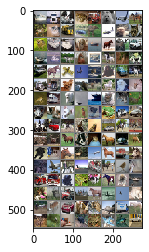

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship truck   cat  frog


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 95 %
Accuracy of  bird : 76 %
Accuracy of   cat : 81 %
Accuracy of  deer : 96 %
Accuracy of   dog : 69 %
Accuracy of  frog : 81 %
Accuracy of horse : 79 %
Accuracy of  ship : 90 %
Accuracy of truck : 79 %
